In [1]:
%matplotlib inline

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import nengo
from nengo import spa
import numpy as np
import tensorflow as tf

import nengo_dl
from nengo.utils.filter_design import cont2discrete

In [2]:
from prophesee.io.psee_loader import PSEELoader

import pathlib
from glob import glob

In [3]:
delta_t = 10000
n = 75
skip = 100

In [4]:
vids = map(PSEELoader, glob("Prophesee_Dataset_n_cars/n-cars_train/cars/*_td.dat"))
# height, width = vid.get_size()
height, width = 120, 120
# vid.seek_time(skip)
event_seqs = [next(vids).load_delta_t(delta_t) for _ in range(n)]
# N = len(event_seqs)

In [24]:
dat = np.zeros((n, delta_t, 29, 29),dtype=np.int8)
for i,block in enumerate(event_seqs):
    for ev in block:
        dat[i,ev[0],ev[1]//4,ev[2]//4] = ev[3]
# for ev in events:
#     dat[ev[0],ev[1],ev[2]] = ev[3]

# dat = decimate(dat,4,axis=2)
# dat = decimate(dat,4,axis=3)

train_data = dat[0:60,:,:,:]
test_data  = dat[60:75,:,:,:]

# train_data = tf.data.Dataset.from_tensor_slices(tf.sparse.from_dense(train_data.reshape((train_data.shape[0], train_data.shape[1], -1))))
# test_data = tf.data.Dataset.from_tensor_slices(tf.sparse.from_dense(test_data.reshape((test_data.shape[0], test_data.shape[1], -1))))

train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

n_in = train_data.shape[-1]

In [6]:
class LMUCell(nengo.Network):
    def __init__(self, units, order, theta, input_d, **kwargs):
        super().__init__(**kwargs)

        # compute the A and B matrices according to the LMU's mathematical derivation
        # (see the paper for details)
        Q = np.arange(order, dtype=np.float64)
        R = (2 * Q + 1)[:, None] / theta
        j, i = np.meshgrid(Q, Q)

        A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R
        B = (-1.0) ** Q[:, None] * R
        C = np.ones((1, order))
        D = np.zeros((1,))

        A, B, _, _, _ = cont2discrete((A, B, C, D), dt=1.0, method="zoh")

        with self:
            nengo_dl.configure_settings(trainable=None)

            # create objects corresponding to the x/u/m/h variables in the above diagram
            self.x = nengo.Node(size_in=input_d)
            self.u = nengo.Node(size_in=1)
            self.m = nengo.Node(size_in=order)
            self.h = nengo.Ensemble(units, 1, neuron_type=nengo.PoissonSpiking(nengo.Tanh()))

            # compute u_t from the above diagram. we have removed e_h and e_m as they
            # are not needed in this task.
            nengo.Connection(
                self.x, self.u, transform=np.ones((1, input_d)), synapse=None
            )

            # compute m_t
            # in this implementation we'll make A and B non-trainable, but they
            # could also be optimized in the same way as the other parameters.
            # note that setting synapse=0 (versus synapse=None) adds a one-timestep
            # delay, so we can think of any connections with synapse=0 as representing
            # value_{t-1}.
            conn_A = nengo.Connection(self.m, self.m, transform=A, synapse=0)
            self.config[conn_A].trainable = False
            conn_B = nengo.Connection(self.u, self.m, transform=B, synapse=None)
            self.config[conn_B].trainable = False

            # compute h_t
            nengo.Connection(
                self.x, self.h, transform=nengo_dl.dists.Glorot(), synapse=None
            )
            nengo.Connection(
                self.h, self.h, transform=nengo_dl.dists.Glorot(), synapse=0
            )
            nengo.Connection(
                self.m,
                self.h,
                transform=nengo_dl.dists.Glorot(),
                synapse=None,
            )

In [18]:
with nengo.Network(seed=0) as net:
    neuron_type = nengo.LIF(amplitude=0.01)
    # remove some unnecessary features to speed up the training
    nengo_dl.configure_settings(
        trainable=None,
        stateful=False,
        # keep_history=False,
    )

    # input node
    inp = nengo.Node(np.zeros(train_data.shape[-1]))

    # lmu cell
    enc = LMUCell(
        units=64,
        order=256,
        theta=train_data.shape[1],
        input_d=train_data.shape[-1],
    )
    conn_enc = nengo.Connection(inp, enc.x, transform=nengo_dl.dists.Glorot(), synapse=None)
    net.config[conn_enc].trainable = False

    # # dense linear readout
    # out = nengo.Node(size_in=10)
    # nengo.Connection(enc.h, out, transform=nengo_dl.dists.Glorot(), synapse=None)
    
    # dec = LMUCell(
    #     units=train_data.shape[-1],
    #     order=128,
    #     theta=train_data.shape[1],
    #     input_d=64,
    # )
    # conn_dec = nengo.Connection(enc.h,dec.x,transform=nengo_dl.dists.Glorot(),synapse=None)
    # net.config[conn_dec].trainable = False
    
    # hid = nengo.Ensemble(train_data.shape[-1], 1, neuron_type=neuron_type)
    # nengo.Connection(enc.h.neurons, hid.neurons, transform=nengo_dl.dists.Glorot(), synapse=None)
    
    
    out = nengo.Node(size_in=train_data.shape[-1])
    nengo.Connection(enc.h.neurons, out, transform=nengo_dl.dists.Glorot(), synapse=None)
    

    # record output. note that we set keep_history=False above, so this will
    # only record the output on the last timestep (which is all we need
    # on this task)
 
    p_c = nengo.Probe(out)
    p_b = nengo.Probe(enc.h.neurons)

In [20]:
minibatch_size = 3

with nengo_dl.Simulator(network=net, minibatch_size=minibatch_size) as sim:
    out = sim.predict(np.ones((minibatch_size, 10, n_in)))
    print(out[p_c].shape,out[p_b].shape)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


(3, 10, 900) (3, 10, 64)


In [21]:
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loop
    sim.fit(train_data, train_data, epochs=4)

    # evaluate performance on test set
    sim.evaluate(test_data, test_data)
    
    # Save the model
    sim.save_params("./LMU_ncars")


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/4
20/20 [==============================] - 459s 23s/step - loss: 2335.7954 - probe_loss: 2335.7954 - probe_1_loss: 0.0000e+00
Epoch 2/4
20/20 [==============================] - 442s 22s/step - loss: 96.1012 - probe_loss: 96.1012 - probe_1_loss: 0.0000e+00
Epoch 3/4
20/20 [==============================] - 428s 21s/step - loss: 151.9393 - probe_loss: 151.9393 - probe_1_loss: 0.0000e+00
Epoch 4/4
5/5 [==============================] - 45s 9s/step - loss: 50859.7617 - probe_loss: 50859.7617 - probe_1_loss: 0.0000e+00


Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


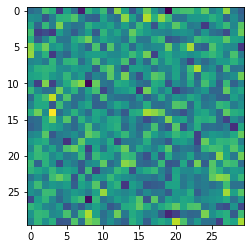

<Figure size 432x288 with 0 Axes>

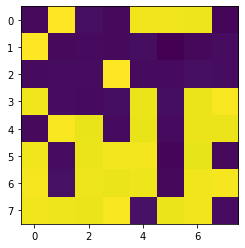

Mean of the hidden space rep: -8.1292035e-07


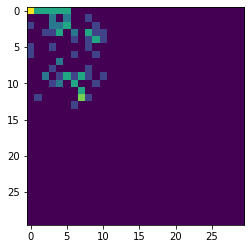

In [15]:
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    #sim.compile(optimizer=tf.optimizers.RMSprop(1e-3), loss=tf.losses.mse)

    # run training loopq
    #sim.fit(train_data, train_data, epochs=n_epochs)

    # evaluate performance on test set
    #sim.evaluate(test_data, test_data)

    # Load the saved model
    sim.load_params("./LMU_ncars")

    # display example output
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.imshow(np.mean(output[p_c][1],axis=0).reshape((30, 30)))
    plt.show()

    # display the latent space representation
    output = sim.predict(test_data[:minibatch_size])
    plt.figure()
    plt.figure()
    plt.imshow(np.mean(output[p_b][1],axis=0).reshape((8, 8)))
    plt.show()
    
    plt.figure()
    plt.imshow(np.mean(test_data[1],axis=0).reshape(30,30))

    hidden_rep = output[p_b][0]
    norm = np.linalg.norm(hidden_rep)
    hidden_rep = hidden_rep/norm
    print('Mean of the hidden space rep:', hidden_rep.mean())

In [16]:
train_data.shape

(60, 10000, 900)